In [1]:
import os


import numpy as np

from dynamic_programming.policy_iteration import PolicyIteration, PolicyIterationTorch
from dynamic_programming.mdp_model import MDPModel
from dynamic_programming.policy import DPPolicy
from envs.env_creator import env_creator
from base_algorithm.eval_policy import EvalDiscreteStatePolicy
import time
import pandas as pd

## Load Data and MDP Model

In [2]:
device = 'cpu'
load_path = os.path.join("tmp", "ibqf-out/ibq_samples.npy")
#load_path = os.path.join("tmp", "ibq_samples_50m.npy")
mdp_save_path = 'tmp/dynamic_programming/mdp_model.pkl'
sa_reward = True
samples = np.load(load_path,allow_pickle=True)[()]


print(samples['rewards'].mean())
print(samples['rewards'].size)
samples['rewards'] = samples['rewards'] + np.abs(samples['rewards'].min())
print(samples['rewards'].min())
print(np.unique(samples['obs']).size)

-185.65064942993163
100000
0.0
70


In [3]:
start = time.time()
mdp_model = MDPModel(states=samples['obs'], next_states=samples['new_obs'], actions=samples['actions'],
                     rewards=samples['rewards'], dones=samples['dones'], device=device, sa_reward=sa_reward)

end = time.time()
print(end - start)


Computing Reward Function
Computing Transition Model
3.065462350845337


In [4]:
mdp_model.save(mdp_save_path)

In [5]:
mdp_model = MDPModel.load(mdp_save_path)

## Train

In [6]:
mdp_model.reward_function.shape

(70, 25)

In [7]:
mdp_model.reward_function

array([[  0.    ,   0.    ,   0.    , ...,   0.    ,   0.    ,   0.    ],
       [  0.    ,   0.    ,   0.    , ...,   0.    ,   0.    ,   0.    ],
       [  0.    ,   0.    , 319.6312, ...,   0.    ,   0.    ,   0.    ],
       ...,
       [  0.    ,   0.    ,   0.    , ...,   0.    ,   0.    , 302.0822],
       [  0.    ,   0.    ,   0.    , ...,   0.    ,   0.    ,   0.    ],
       [  0.    ,   0.    ,   0.    , ...,   0.    ,   0.    ,   0.    ]],
      dtype=float32)

0
0
60.24599862670897
30.09287631404115
15.031391718863546
7.508180163572348
3.7503359917043895
1.873292827856318
0.935709767514254
0.46738702887336103
0.23345982092223494
0.11661318055067227
0.05824828368506019
0.029095017700683456
0.014532961341501505
0.007259214190071361
0.0036259774879567885
0.0018111757552219387
0.000904682289728953
0.00045188880372393214
0.00022571845747165753
0.0001127463694956532
5.631681156614832e-05
1
516.9692835872381
474.8974462892934
434.674137130545
401.5993147833592
369.70063701320396
339.1226731926172
310.4442107970676
283.836820864723
259.3006111454911
236.757677912924
216.09492145643935
197.18517700539542
179.89814800678232
164.1062024453131
149.68742486507745
136.5271322675526
124.51850349595952
113.5626907918595
103.56863143855571
94.4526916631894
86.13822395584793
78.55508766008006
71.63916312467427
65.33187737394928
59.579751471200325
54.33397486193735
49.55000894646764
45.187220276920925
41.20854267389586
37.58016693534864
34.271256488241306
31.2

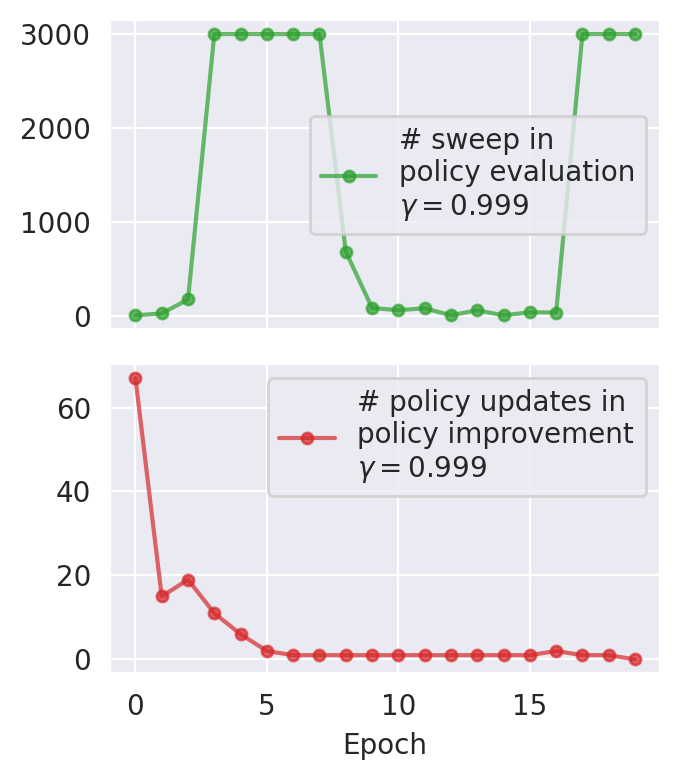

In [8]:
solver = PolicyIteration(mdp_model.reward_function, mdp_model.transition_model, gamma=0.999, sa_reward=sa_reward)
solver.train(total_epochs=100,eval_epochs=3000)
policy_save_path = 'tmp/dynamic_programming/ib_policy.pkl'

trained_policy = DPPolicy(policy_table=solver.policy, state_to_index=mdp_model.state_to_index,
                        index_to_action=mdp_model.index_to_actions)
trained_policy.save(policy_save_path)

In [9]:
print(solver.values)


[330529.13128877 330481.27128498 334249.01885406 330497.17999783
 334278.35484957 334277.18893965 334279.53557182 334405.74378846
 334315.10900686 334339.31345226 330293.28147866 330367.20125186
 330868.03699718 330605.23943436 330335.65259537 334249.92826962
 334274.62533122 334240.27598665 334300.95324275 330245.28013573
 330338.53505736 330090.75049887 330042.99001649 334616.92819315
 330039.41493636 334622.22456053 334272.71758696 334337.66936174
 334332.51095927 334310.76672718 334315.46216795 331677.90355
 334420.13694014 333395.69925163 334632.22323379 333381.40429553
 332978.60843593 332204.77141433 334626.89316757 334646.89768309
 334133.42234044 334339.65146066 334372.86463216 331494.76949666
 333280.09960969 333847.26964704 333035.9881197  331820.42879984
 332152.61681017 334227.0381436  334087.71009725 333533.45501647
 333820.51722602 332779.30402978 334245.61491493 334269.03132651
 334599.84786053 334437.54412572 333959.79386195 334444.07850133
 334335.61339349 333938.0603

In [10]:


steps_per_episode = 1000
env_kwargs = {'steps_per_episode': steps_per_episode,'device':device, 'config':None}

policy = DPPolicy.load(policy_save_path)
algo = EvalDiscreteStatePolicy(policy=policy,env_creator=env_creator,env_kwargs=env_kwargs)

Episode 9 Reward: -184.19961439056848 || New State Found: False


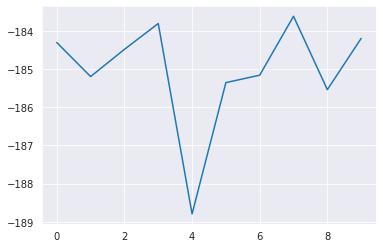

In [11]:
algo.evaluate(epochs=10)

In [12]:
df = pd.DataFrame(algo.eval_trajectories[0]['info'])
df.head()

,setpoint,velocity,gain,shift,fatigue,consumption,op_cost_t0,op_cost_t1,op_cost_t2,op_cost_t3,...,op_cost_t5,op_cost_t6,op_cost_t7,op_cost_t8,op_cost_t9,ml1,ml2,ml3,hv,hg
0,70,49.0,50.0,55.751534,26.865017,129.066096,104.584986,104.584986,104.584986,104.584986,...,104.584986,104.584986,104.584986,104.584986,100.484150,1,1,0.0,0.097296,0.056708
1,70,48.0,50.0,61.503069,30.448687,121.216361,104.584986,104.584986,104.584986,104.584986,...,104.584986,104.584986,104.584986,100.484150,96.544110,1,1,1.0,0.122813,0.125128
2,70,47.0,50.0,67.254603,26.678770,114.569901,104.584986,104.584986,104.584986,104.584986,...,104.584986,104.584986,100.484150,96.544110,92.758561,1,1,2.0,0.117375,0.152593
3,70,46.0,40.0,67.254603,37.108137,113.514979,104.584986,104.584986,104.584986,104.584986,...,104.584986,100.484150,96.544110,92.758561,69.407852,1,1,3.0,0.137919,0.218355
4,70,46.0,30.0,73.006137,29.839519,107.275016,104.584986,104.584986,104.584986,104.584986,...,100.484150,96.544110,92.758561,69.407852,54.054889,1,1,4.0,0.124936,0.212003


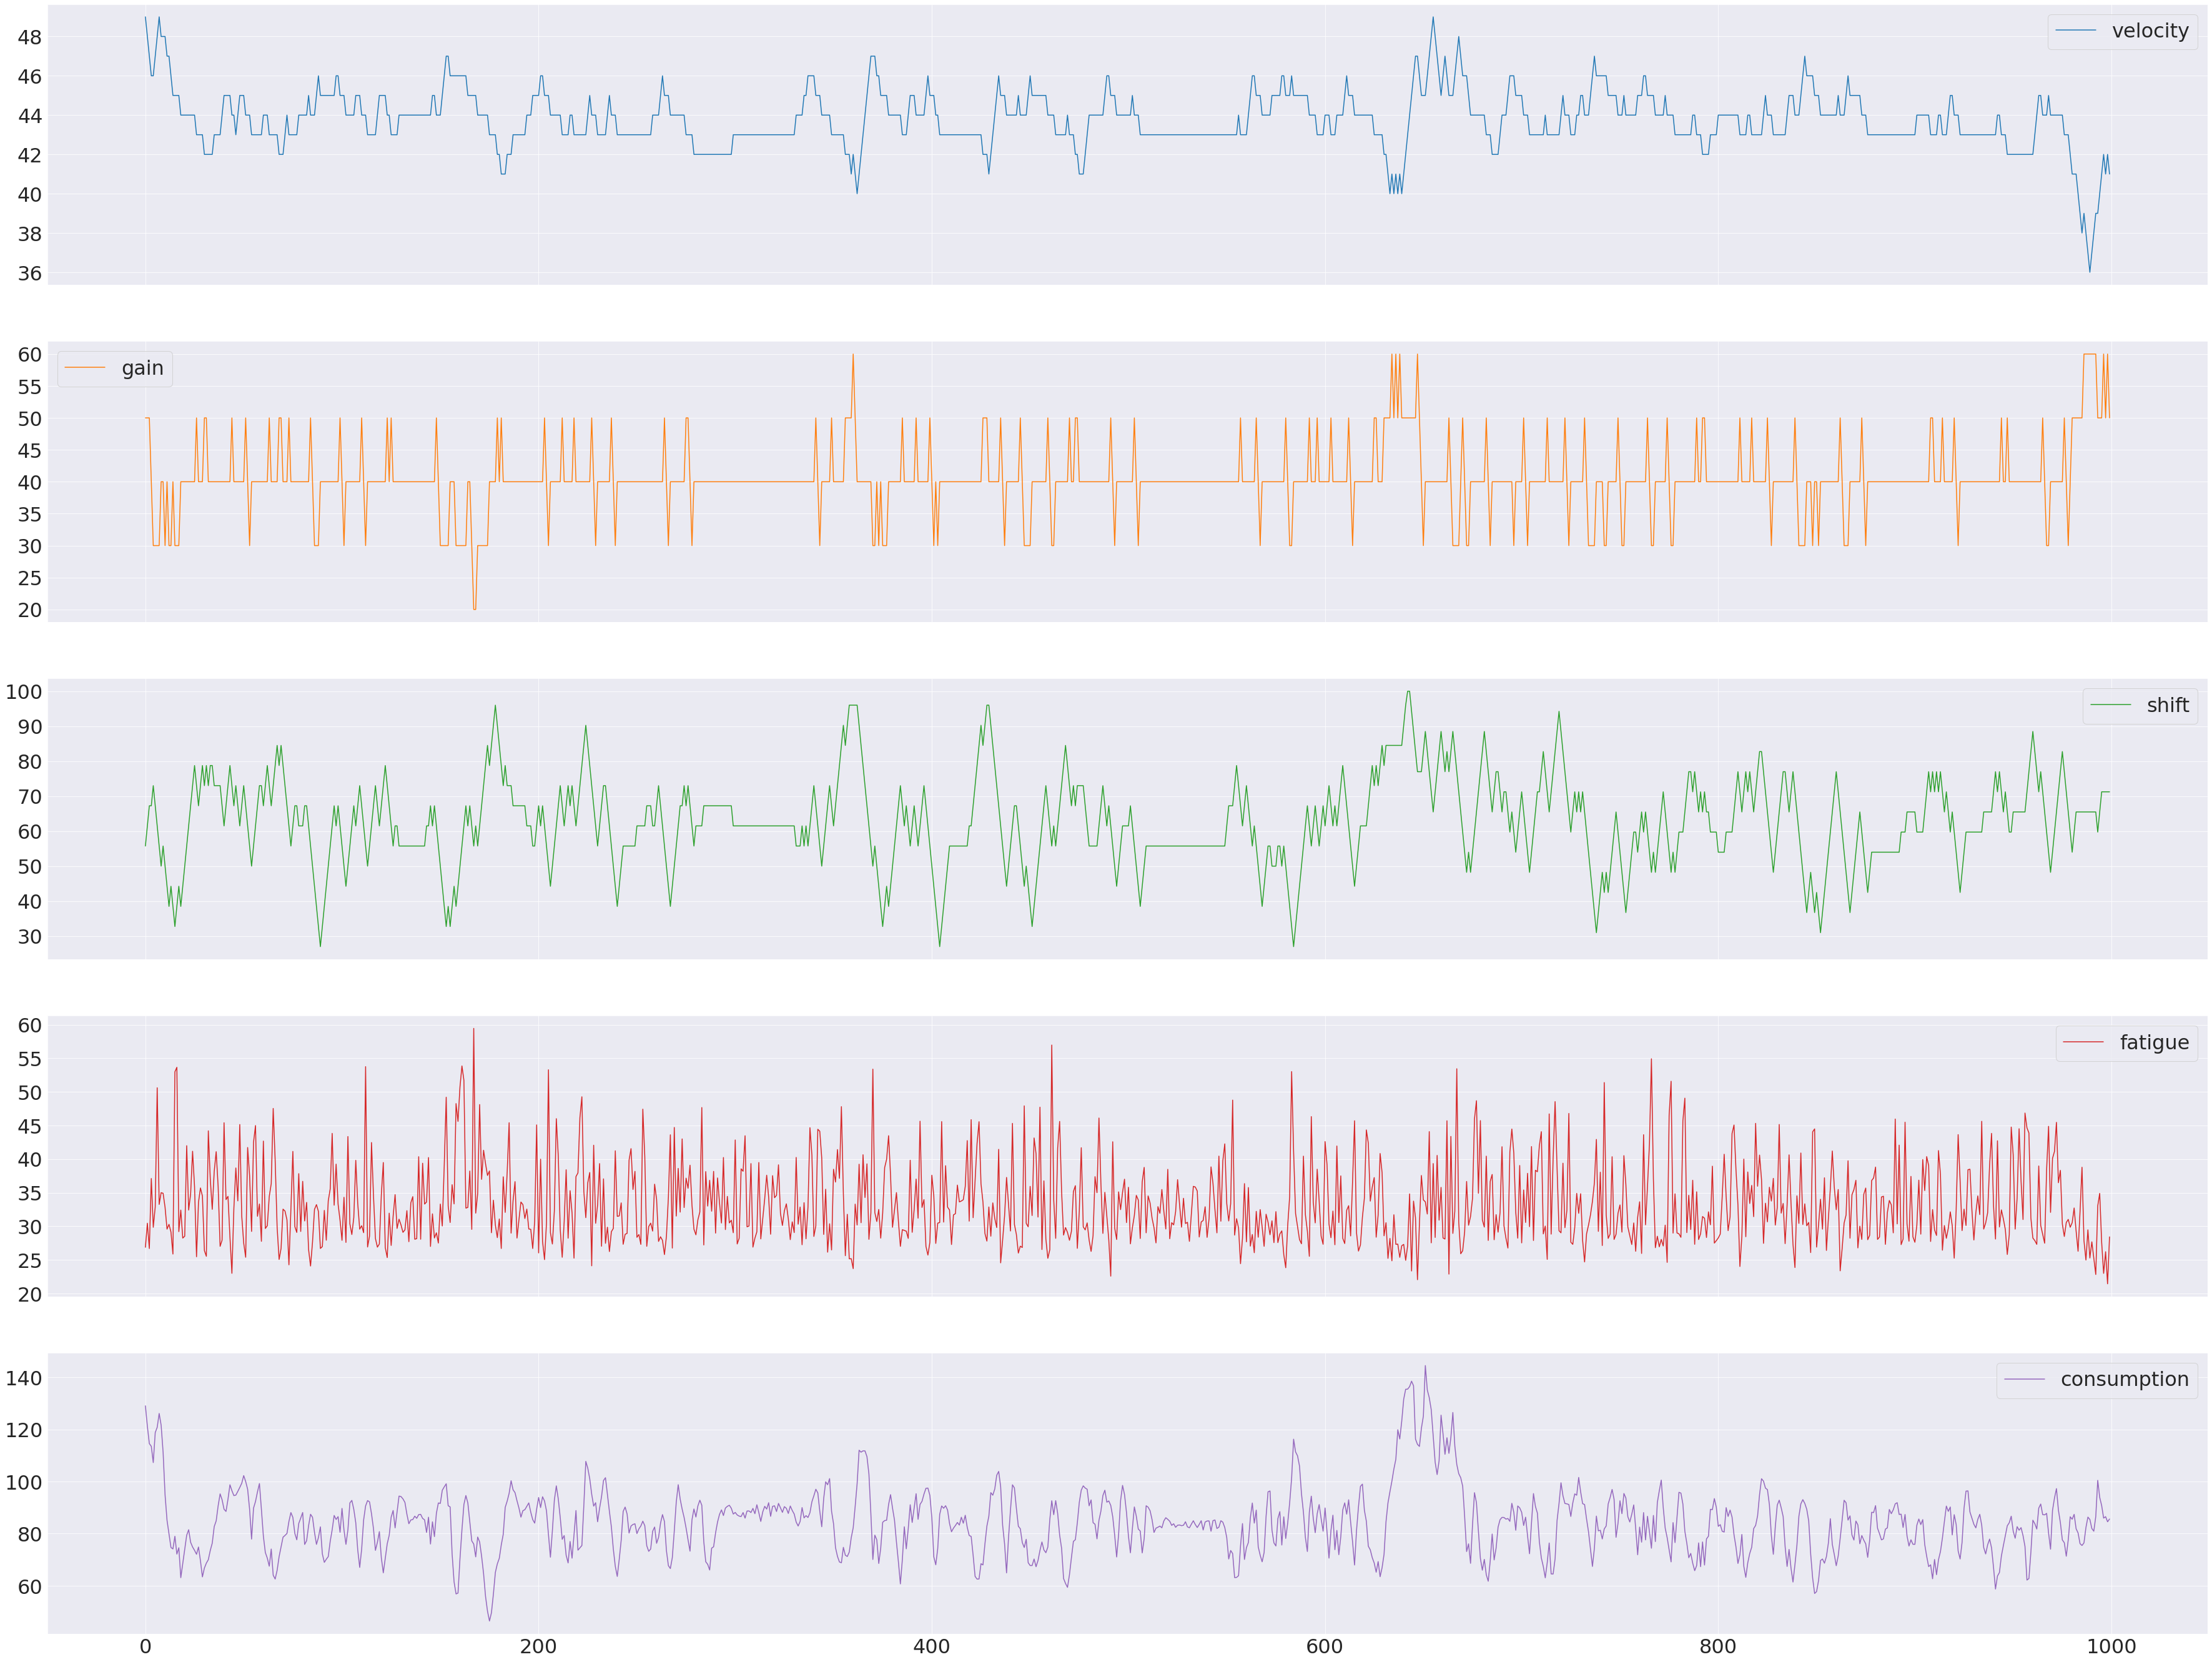

In [13]:
axes = df[['velocity','gain','shift','fatigue','consumption']].plot(subplots=True, figsize=(62, 48), fontsize=32)
for a in axes:
        a.legend(loc='best', prop={'size': 32})